In [3]:
# Montar Google Drive para acceder al dataset
from google.colab import drive
drive.mount('/content/drive')

data_dir = '/content/drive/MyDrive/MNA/Colab Notebooks/MNA/Navegacion autonoma/Actividad 4.1 - Deteccion de Peatones con Keras/Train pics'



ModuleNotFoundError: No module named 'google'

In [8]:
data_dir='INRIA_Person/'

In [54]:
# Importar librerías usadas en la aplicación
# !pip install keras

import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import keras #Para construir redes neuronales
from keras.models import Sequential #Modelo secuencial
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout #Dense para capas conectadas y Flatten para aplanar la entrada
from keras.optimizers import Adam #Optimizador Adam
import keras_metrics
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator #Cargar y procesar imagenes desde carpetas.
                                                                    #Se utiliza Tensorflow porque en versiones modernas de Keras, ImageDataGenerator
                                                                    #ya no se importa desde Keras, se debe importar ahora desde tensorflow.keras

In [9]:
# # Normalización y división de entrenamiento/validación
# datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# # Crear generador para entrenamiento
# train_gen = datagen.flow_from_directory(
#     data_dir,               #Dirección a las imágenes
#     target_size=(64, 128),  # Tamaño al que se redimensionan las imágenes
#     batch_size=32,          # Agrupa las imagenes en paquetes de 32 para ser procesadas en paquetes
#     class_mode='binary',  # Salida binaria
#     subset='training'  # Usa el 80% para entrenamiento
# )

# # Crear generador para validación
# val_gen = datagen.flow_from_directory(
#     data_dir,
#     target_size=(64, 128),
#     batch_size=32,
#     class_mode='binary',
#     subset='validation'  # Usa el 20% para validación
# )


# Data augmentation + normalización para entrenamiento
train_datagen = ImageDataGenerator(
    rescale=1./255,          # Normaliza los pixeles a [0,1]
    validation_split=0.2,    # Divide el dataset en entrenamiento y validación
    rotation_range=10,       # Rota imágenes hasta 10 grados para variedad
    width_shift_range=0.1,   # Desplaza horizontalmente hasta 10%
    height_shift_range=0.1,  # Desplaza verticalmente hasta 10%
    zoom_range=0.1,          # Zoom aleatorio hasta 10%
    horizontal_flip=True     # Voltea horizontalmente (solo si aplica a tu problema)
)

# Solo normalización para validación (sin augmentations)
val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# Generador para entrenamiento usando augmentations
train_gen = train_datagen.flow_from_directory(
    data_dir,               # Carpeta con imágenes organizadas en subcarpetas por clase
    target_size=(64, 128),  # Redimensiona imágenes a 64x128 (ancho x alto)
    batch_size=32,          # Procesa en lotes de 32 imágenes
    class_mode='binary',    # Clasificación binaria
    subset='training'       # Usa el 80% para entrenamiento
)

# Generador para validación sin augmentations
val_gen = val_datagen.flow_from_directory(
    data_dir,
    target_size=(64, 128),
    batch_size=32,
    class_mode='binary',
    subset='validation'     # Usa el 20% para validación
)

Found 1467 images belonging to 2 classes.
Found 365 images belonging to 2 classes.


In [11]:
print(f"Imágenes en entrenamiento: {train_gen.samples}")
print(f"Imágenes en validación: {val_gen.samples}")
print(f"Clases: {train_gen.class_indices}")

Imágenes en entrenamiento: 1467
Imágenes en validación: 365
Clases: {'neg': 0, 'pos': 1}


In [60]:
# Crear modelo secuencial CNN
model = Sequential()
# # Aplanar la imagen de entrada (64x128x3 - vector)
# model.add(Flatten(input_shape=(128, 64, 3)))  # alto=128, ancho=64, canales=3 - 24,576 entradas

#Primera capa convolucional
model.add(Conv2D(64, (3, 3), activation='sigmoid', input_shape=(128, 64, 3)))  # Filtros 3x3
model.add(MaxPooling2D(pool_size=(2, 2)))  # Reduce tamaño espacial a la mitad

#Segunda capa convolucional
model.add(Conv2D(64, (3, 3), activation='sigmoid'))
model.add(MaxPooling2D(pool_size=(2, 2)))

#Tercera capa convolucional
model.add(Conv2D(128, (3, 3), activation='sigmoid'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Aplanar para conectar con capas densas
model.add(Flatten())

# Capa oculta totalmente conectada con Dropout para regularización
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.4))

model.add(Dense(1, activation='sigmoid')) # Capa de salida: clasificación binaria

# Callbacks: parada temprana y reducción del LR si no mejora
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate = 0.1), loss='binary_crossentropy', metrics=['recall'])
#model.compile(optimizer="sdg", loss='binary_crossentropy', metrics=[keras_metrics.precision(), keras_metrics.recall()])


In [61]:
#Resumen del modelo
model.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_36 (Conv2D)              │ (None, 126, 62, 64)    │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_36 (MaxPooling2D) │ (None, 63, 31, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 61, 29, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_37 (MaxPooling2D) │ (None, 30, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 28, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_38 (MaxPooling2D) │ (None, 14, 6, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_12 (Flatten)            │ (None, 10752)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 256)            │     2,752,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,865,601 (10.93 MB)

 Trainable params: 2,865,601 (10.93 MB)

 Non-trainable params: 0 (0.00 B)

In [62]:
# Entrenar el modelo
hist = model.fit(train_gen, validation_data=val_gen, verbose = 2, epochs=20, callbacks=[early_stop, reduce_lr], shuffle = 'true')


Epoch 1/20
46/46 - 30s - 659ms/step - loss: 115.2186 - recall: 0.0976 - val_loss: 0.6377 - val_recall: 0.0000e+00 - learning_rate: 0.1000
Epoch 2/20
46/46 - 27s - 590ms/step - loss: 0.6390 - recall: 0.0000e+00 - val_loss: 0.6375 - val_recall: 0.0000e+00 - learning_rate: 0.1000
Epoch 3/20
46/46 - 27s - 590ms/step - loss: 0.6393 - recall: 0.0000e+00 - val_loss: 0.6389 - val_recall: 0.0000e+00 - learning_rate: 0.1000
Epoch 4/20
46/46 - 41s - 889ms/step - loss: 0.6389 - recall: 0.0000e+00 - val_loss: 0.6372 - val_recall: 0.0000e+00 - learning_rate: 0.1000
Epoch 5/20
46/46 - 27s - 591ms/step - loss: 0.6384 - recall: 0.0000e+00 - val_loss: 0.6387 - val_recall: 0.0000e+00 - learning_rate: 0.1000
Epoch 6/20

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.05000000074505806.
46/46 - 27s - 595ms/step - loss: 0.6394 - recall: 0.0000e+00 - val_loss: 0.6372 - val_recall: 0.0000e+00 - learning_rate: 0.1000
Epoch 7/20
46/46 - 30s - 643ms/step - loss: 0.6383 - recall: 0.0000e+00 - val_loss: 0.6

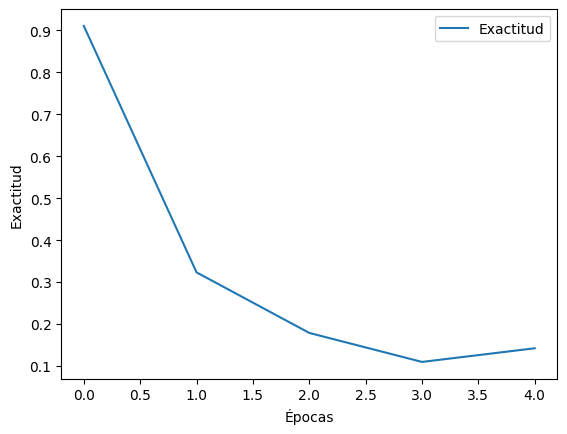

In [46]:
#Graficar error y exactitud del modelo
plt.plot(hist.history['recall'])
plt.legend(['Exactitud'])
plt.xlabel('Épocas')
plt.ylabel('Exactitud')
plt.show()

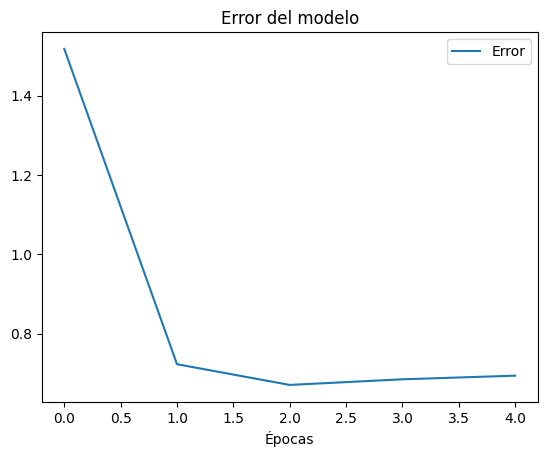

In [47]:
plt.plot(hist.history['loss'])
plt.legend(['Error'])
plt.title('Error del modelo')
plt.xlabel('Épocas')
plt.show()

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.6311 - recall: 0.0000e+00
Precisión en test: 0.0000, Pérdida: 0.6371


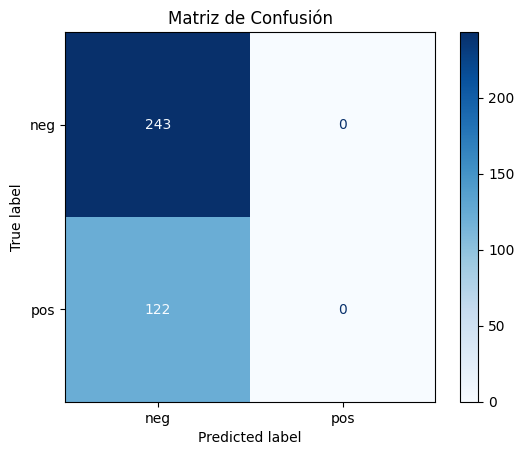

In [48]:
# Listas para almacenar todas las imágenes y etiquetas
X_test = []
y_test = []

# Calculamos cuántos batchs hay en total en val_gen
num_batches = int(np.ceil(val_gen.samples / val_gen.batch_size))

# Recorremos todos los lotes del generador de validación
for _ in range(num_batches):
    x_batch, y_batch = next(val_gen) # Obtenemos un lote de imágenes y etiquetas
    X_test.extend(x_batch)          # Agregamos las imágenes a la lista
    y_test.extend(y_batch)

# Convertimos las listas a arreglos
X_test = np.array(X_test)
y_test = np.array(y_test)

# Predecir las clases
y_predict = (model.predict(X_test) > 0.5).astype(int).flatten()

# Evaluar en conjunto de prueba
loss, acc = model.evaluate(X_test, y_test)
print(f"Precisión en test: {acc:.4f}, Pérdida: {loss:.4f}")

# Matriz de confusión
cm = confusion_matrix(y_test, y_predict)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=val_gen.class_indices.keys())
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusión")
plt.show()
